# University of Virginia, School of Data Science
## Final Project | DS 7200: Distributed Computing
### Team 5: Gia Smith, Luz Melo, Meesun Yang
---

# STEP 1: Data Import and Preprocessing

(Preprocessing include such tasks as imputing, binning, filtering, outlier treatment, feature engineering, 
text processing)

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler
from pyspark.sql import functions as F
from pyspark.sql import SQLContext
from pyspark.sql.window import Window
from pyspark.sql.functions import lit
from pyspark.sql.functions import col
from pyspark.sql.functions import mean, stddev, corr
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer 
from pyspark.sql.types import StructType, StructField, DateType, FloatType, LongType

from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
# set up the session
spark = SparkSession.builder.getOrCreate()

/opt/conda/lib/python3.7/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/12/06 22:45:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## The Data

In [3]:
# Read in stock data. Source: Yahoo! finance
path1 = 'KO.csv'
path2 = 'KO_1st_toLoad.csv'
path3 = 'KO_quarterly_valuation_measures.csv'
path4 = 'KO_quarterly_financials.csv'
path5 = 'KO_quarterly_balance-sheet.csv'
path6 = 'KO_quarterly_cash-flow.csv'
path7 = 'KO_merged_data.csv'
path8 = 'filtered_merged_data.csv'
path9 = 'KO_filtered_merged_data.csv'
path10 = 'KOv3.csv'
path11 = 'KO_class.csv'

In [4]:
# set up schema
stock_schema = StructType([StructField('Date',DateType(),False),
                           StructField('Open',FloatType(),False),
                           StructField('High',FloatType(),False),
                           StructField('Low',FloatType(),False),
                           StructField('Close',FloatType(),False),
                           StructField('Adj Close',FloatType(),False),
                           StructField('Volume',FloatType(),False),
                         ])

### Historical Data: Daily

In [5]:
df1 = spark.read.csv(path1, header=True, schema=stock_schema)
df1.show(10)

+----------+--------+--------+--------+--------+---------+---------+
|      Date|    Open|    High|     Low|   Close|Adj Close|   Volume|
+----------+--------+--------+--------+--------+---------+---------+
|1962-01-02|0.263021|0.270182|0.263021|0.263021| 0.048528| 806400.0|
|1962-01-03|0.259115|0.259115|0.253255|0.257161| 0.047447|1574400.0|
|1962-01-04|0.257813|0.261068|0.257813|0.259115| 0.047807| 844800.0|
|1962-01-05|0.259115| 0.26237|0.252604|0.253255| 0.046726|1420800.0|
|1962-01-08|0.251302|0.251302|0.245768|0.250651| 0.046246|2035200.0|
|1962-01-09|0.250651| 0.25651|0.248698|0.255208| 0.047087| 960000.0|
|1962-01-10|0.255208|0.260091|0.252604| 0.25651| 0.047327|1612800.0|
|1962-01-11| 0.25651|0.259115|0.255208|0.259115| 0.047807| 614400.0|
|1962-01-12|0.259115|0.259115|0.254557|0.257161| 0.047447| 883200.0|
|1962-01-15| 0.25651| 0.25651|0.253906|0.254557| 0.046966| 614400.0|
+----------+--------+--------+--------+--------+---------+---------+
only showing top 10 rows



In [6]:
df1.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Open: float (nullable = true)
 |-- High: float (nullable = true)
 |-- Low: float (nullable = true)
 |-- Close: float (nullable = true)
 |-- Adj Close: float (nullable = true)
 |-- Volume: float (nullable = true)



### Historical Data: Quarterly

In [7]:
df2 = spark.read.csv(path2, header=True, inferSchema=True)
df2.show(10)

+----------+--------+--------+--------+--------+---------+---------+
|      Date|    Open|    High|     Low|   Close|Adj Close|   Volume|
+----------+--------+--------+--------+--------+---------+---------+
| 3/31/1985|1.458333|1.505208|1.408854|1.427083| 0.565683|331833600|
| 6/30/1985|1.445313|1.559896|1.401042|1.505208| 0.603144|522912000|
| 9/30/1985|1.453125|1.510417|1.440104|1.492188| 0.604408|258590400|
|12/31/1985|1.760417|1.770833|1.598958|1.747396| 0.714215|288134400|
| 3/31/1986|  2.1875|     2.5|2.052083|2.322917| 0.957008|416294400|
| 6/30/1986|2.742188|2.804688|2.359375|2.445313| 1.014374|364022400|
| 9/30/1986|2.117188|2.453125|2.109375|2.289063| 0.956324|255110400|
|12/31/1986|2.359375|2.773438|2.359375|2.664063| 1.121004|392235200|
| 3/31/1987|2.859375|  2.9375|2.546875|2.664063| 1.128003|319137600|
| 6/30/1987|2.765625|2.992188|2.679688|2.976563| 1.268484|321331200|
+----------+--------+--------+--------+--------+---------+---------+
only showing top 10 rows



### Validation Measures

In [8]:
df3 = spark.read.csv(path3, header=True, inferSchema=True)
df3.show(10)

+----------+---------------+---------------+-------+--------------+--------+-------+-------+----------------------------+---------------------------+
|      Date|      MarketCap|EnterpriseValue|PeRatio|ForwardPeRatio|PegRatio|PsRatio|PbRatio|EnterprisesValueRevenueRatio|EnterprisesValueEBITDARatio|
+----------+---------------+---------------+-------+--------------+--------+-------+-------+----------------------------+---------------------------+
|       ttm|247,558,674,760|272,294,674,760| 23.182|         20.45|   2.698|  5.522|  9.404|                       6.047|                     17.509|
| 9/30/2023|242,057,520,000|267,988,520,000| 23.228|        19.763|   2.582|  5.509|  9.305|                       22.42|                     63.883|
| 6/30/2023|260,391,280,000|288,496,280,000| 26.529|        23.202|   3.282|  6.019| 10.326|                      24.098|                     81.611|
| 3/31/2023|268,279,750,000|295,797,750,000| 28.324|        23.866|   3.378|  6.275|  11.13|        

### Income Statement

In [9]:
df4 = spark.read.csv(path4, header=True, inferSchema=True)
#df4.show(10)

### Balence Sheet

In [10]:
df5 = spark.read.csv(path5, header=True, inferSchema=True)
#df5.show(10)

### Cash Flow

In [11]:
df6 = spark.read.csv(path6, header=True, inferSchema=True)
#df6.show(10)

### Merge Datasets: Valuation Measures, Income Statement, Balance Sheet, and Cash Flow.

In [12]:
merged_df = df3.join(df4, 'Date', 'inner') \
               .join(df5, 'Date', 'inner') \
               .join(df6, 'Date', 'inner')
               
# Save the merged DataFrame to a CSV file
output_path = "merged_data.csv"
#merged_df.write.csv(output_path, header=True, mode="overwrite")
#len(merged_df.columns)

In [13]:
merged_df = spark.read.csv(path7, header=True, inferSchema=True)
len(merged_df.columns)

214

### Removing columns with null values

In [14]:
# Identify columns without null values
columns_without_null = [col_name for col_name in merged_df.columns if merged_df.filter(col(col_name).isNull()).count() == 0]
# Identify colunmns with null values
columns_with_null = [col_name for col_name in merged_df.columns if merged_df.filter(col(col_name).isNull()).count() != 0]

# Select only columns without null values
filtered_merged_df = merged_df.select(*columns_without_null)

# Total number of columns without null values
len(columns_without_null)
len(filtered_merged_df.columns)

102

In [15]:
# Save the filtered merged DataFrame to a CSV file
output_path = "filtered_merged_data.csv"
#filtered_merged_df.write.csv(output_path, header=True, mode="overwrite")

#filtered_merged_df = spark.read.csv(path8, header=True, inferSchema=True)
#len(filtered_merged_df.columns)

### Join filtered historical data and merged dataset

In [16]:
final_merged_df = df1.join(filtered_merged_df, 'Date', 'inner')

# Save the merged DataFrame to a CSV file
output_path = "KO_filtered_merged_df.csv"
#final_merged_df.write.csv(output_path, header=True, mode="overwrite")

df9 = spark.read.csv(path9, header=True, inferSchema=True)
len(df9.columns)

108

## Financial Earnings Data: Quarterly

In [17]:
df10 = spark.read.csv(path10, header=True, inferSchema=True)
len(df10.columns)

109

### Add Rate of Return Column

In [18]:
# Convert the date column to a timestamp
df = df1.withColumn("Date", F.to_date("Date"))

# Define a window specification
window_spec = Window().orderBy("Date")

# Calculate the rate of return using the lag function
df = df.withColumn("prev_Close", F.lag("Close").over(window_spec))
df = df.withColumn("prev_Open", F.lag("Open").over(window_spec))
df = df.withColumn("prev_High", F.lag("High").over(window_spec))
df = df.withColumn("prev_Low", F.lag("Low").over(window_spec))
df = df.withColumn("prev_Volume", F.lag("Volume").over(window_spec))

# Calculate the rate of return
df = df.withColumn("Rate_of_Return", ((df["Close"] - df["prev_Close"]) / df["prev_Close"]) * 100)

# Drop the columns used for lagging
#df = df.drop("prev_close") #, "prev_close", "prev_high", "prev_low", "prev_volume")

# Drop rows with null values in the "Rate_of_Return" column
df = df.dropna(subset=["Rate_of_Return"])

# Show the result
df.show()

23/12/06 22:46:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/06 22:46:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/06 22:46:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/06 22:46:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/06 22:46:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
+----------+--------+--------+--------+--------+---------+---------+----------+---------+---------+--------+-----------+-------------------+
|      Date|    Open|    High|    

# STEP 2: Data Splitting and Sampling

(Sampling may not be needed, but splitting is a must)

For all the models we used 80% of the data for training and 20% of the data for testing. This is performed during the model construction as many different datasets are used for various models. Please refer to STEP 4: Model Construction. 

# STEP 3: Exploratory Data Analysis

(Include at least two graphs)

## Historical Data: Daily

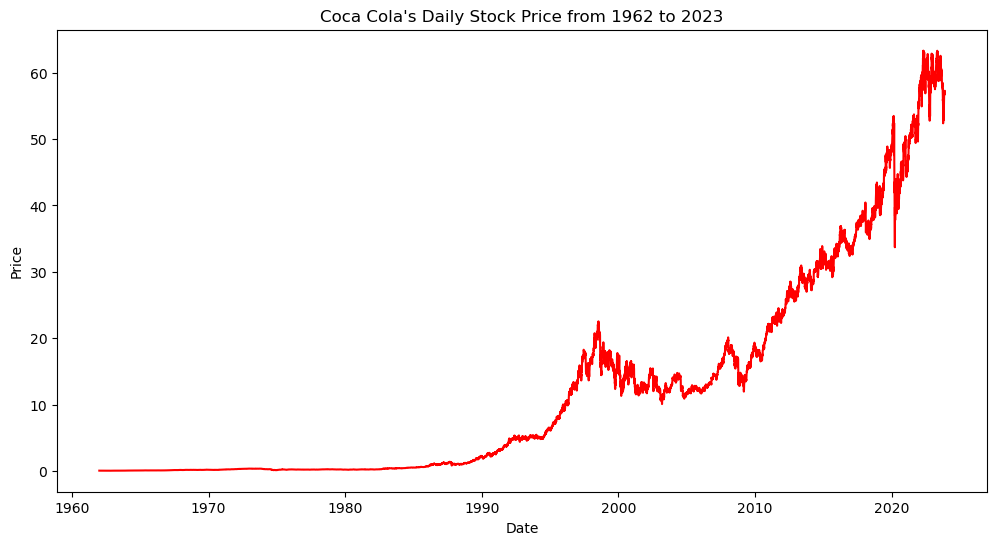

In [19]:
# Assuming 'Date' and 'Volume' are column names in your DataFrame
prices_and_volume = df1.select("Date", "Adj Close", "Volume").collect()
dates = [row.Date for row in prices_and_volume]
prices = [row["Adj Close"] for row in prices_and_volume]
volume = [row.Volume for row in prices_and_volume]

# Creating subplots
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting stock prices on the first y-axis
ax1.plot(dates, prices, color='red', label='Stock Price')
ax1.set_xlabel("Date")
ax1.set_ylabel("Price")
ax1.tick_params(axis='y')
ax1.set_title("Coca Cola's Daily Stock Price from 1962 to 2023")


# Displaying the plot
plt.show()

### Statistical Information

In [20]:
mean_price = df1.select(mean("Close")).first()[0]
stddev_price = df1.select(stddev("Close")).first()[0]
corr_price_volume = df1.select(corr("Close", "Volume")).first()[0]

print("Mean Price:", mean_price)
print("Standard Deviation Price:", stddev_price)
print("Correlation between Price and Volume:", corr_price_volume)

Mean Price: 17.44691300745597
Standard Deviation Price: 18.399699444096413
Correlation between Price and Volume: 0.47349443753791776


In [21]:
df1.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+-----------------+
|summary|              Open|              High|               Low|             Close|         Adj Close|           Volume|
+-------+------------------+------------------+------------------+------------------+------------------+-----------------+
|  count|             15578|             15578|             15578|             15578|             15578|            15578|
|   mean|17.443087905915117|17.584551596108934| 17.29806420616332| 17.44691300745597|12.287431249795091|9212160.328668635|
| stddev| 18.39905733332124|18.532486456813324|18.260003923963637|18.399699444096413|15.744719260632824|7942933.496331465|
|    min|          0.192708|          0.193359|          0.182292|          0.192057|          0.035927|          76800.0|
|    max|              67.0|              67.2|             65.72|             66.21|          63.31803|        1.24169E8|
+-------+-------

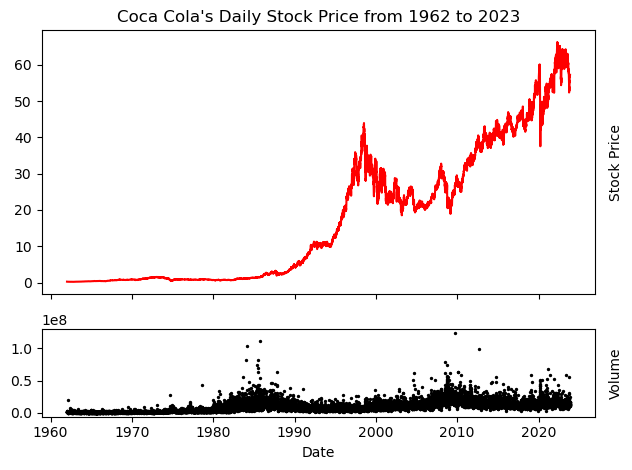

In [22]:
start_date = pd.to_datetime('1962-01-02')
end_date = pd.to_datetime('2023-11-17')

# Convert the 'Date' column to a datetime type in PySpark
df1 = df1.withColumn('Date', F.to_date(df1['Date']))

# Filter the DataFrame based on the date range
df2 = df1.filter((df1['Date'] >= start_date) & (df1['Date'] <= end_date))

# Convert the filtered DataFrame to a Pandas DataFrame for plotting
pd_df2 = df2.toPandas()

# Set the 'Date' column as the index
pd_df2.set_index('Date', inplace=True)

# Plotting
fig, (top_plt, bottom_plt) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

# Top plot (stock prices)
top_plt.plot(pd_df2.index, pd_df2["Close"], color='red')
top_plt.set_title("Coca Cola's Daily Stock Price from 1962 to 2023")
top_plt.set_ylabel('Stock Price')

# Bottom plot (volume)
bottom_plt.scatter(pd_df2.index, pd_df2['Volume'], color = "black", s=2)
bottom_plt.set_ylabel('Volume')

# Add x-axis label to the bottom plot
bottom_plt.set_xlabel('Date')

# Add labels on the right side
top_plt.yaxis.set_label_coords(1.05, 0.5)
bottom_plt.yaxis.set_label_coords(1.05, 0.5)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## Historical Data: Quaterly

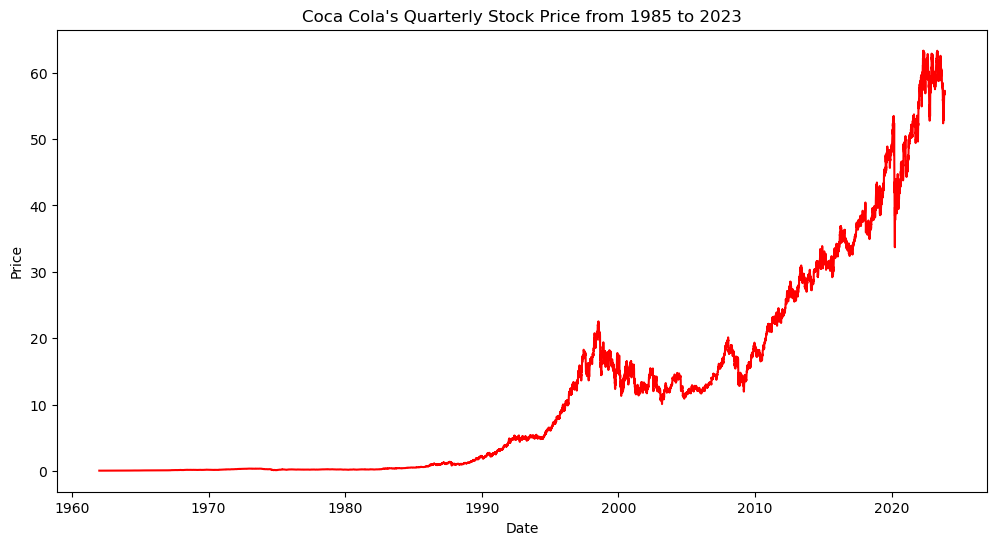

In [23]:
# Imports
import matplotlib.pyplot as plt

# Assuming 'Date' and 'Volume' are column names in your DataFrame
prices_and_volume = df2.select("Date", "Adj Close", "Volume").collect()
dates = [row.Date for row in prices_and_volume]
prices = [row["Adj Close"] for row in prices_and_volume]
volume = [row.Volume for row in prices_and_volume]

# Creating subplots
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting stock prices on the first y-axis
ax1.plot(dates, prices, color='red', label='Stock Price')
ax1.set_xlabel("Date")
ax1.set_ylabel("Price")
ax1.tick_params(axis='y')
ax1.set_title("Coca Cola's Quarterly Stock Price from 1985 to 2023")


# Displaying the plot
plt.show()

### Statistical Information

In [24]:
mean_price = df2.select(mean("Close")).first()[0]
stddev_price = df2.select(stddev("Close")).first()[0]
corr_price_volume = df2.select(corr("Close", "Volume")).first()[0]

print("Mean Price:", mean_price)
print("Standard Deviation Price:", stddev_price)
print("Correlation between Price and Volume:", corr_price_volume)

Mean Price: 17.448016165446283
Standard Deviation Price: 18.399774888439467
Correlation between Price and Volume: 0.47346126218312706


In [25]:
df2.describe().show()

+-------+------------------+------------------+-----------------+------------------+------------------+-----------------+
|summary|              Open|              High|              Low|             Close|         Adj Close|           Volume|
+-------+------------------+------------------+-----------------+------------------+------------------+-----------------+
|  count|             15577|             15577|            15577|             15577|             15577|            15577|
|   mean|17.444190818344573| 17.58566313039555|17.29915780847531|17.448016165446283| 12.28821695328415| 9212699.95506195|
| stddev| 18.39913296841806|18.532562057904435|18.26007989727352|18.399774888439467|15.744919259192999|7942902.898134615|
|    min|          0.192708|          0.193359|         0.182292|          0.192057|          0.035927|          76800.0|
|    max|              67.0|              67.2|            65.72|             66.21|          63.31803|        1.24169E8|
+-------+---------------

## Questions to Analyze Using PySpark

In this section, we will give answers to some questions data using PySpark’s data preprocessing technique

- What is the average adjusted closing price?
- On what day stock price was the highest?
- For how many days the adjusted closing value was less than the average?
- On what days was the volume the higest? Show the top 20 dates.
- What is the maximum and minimum volume of stock traded?

**What is the average adjusted closing price?**

In [26]:
from pyspark.sql.functions import avg

# Calculate the average closing price
avg_close = df1.select(avg("Close")).first()[0]

print(f"The average closing price is: {avg_close}")

The average closing price is: 17.44691300745597


**On what day stock price was the highest?**

In [27]:
from pyspark.sql.functions import col, max

# Assuming the closing price column is named 'Close'
max_close_row = df1.select("Date", "Adj Close").orderBy(col("Adj Close").desc()).first()

print(f"On {max_close_row['Date']}, the stock price was the highest: {max_close_row['Adj Close']}")

On 2022-04-21, the stock price was the highest: 63.318031311035156


**For how many days the adjusted closing value was less than the average?**

In [28]:
# Filter the days where the closing value was less than the average
below_avg_days = df1.filter(col("Adj Close") < avg_close).count()

# Calculate the total number of days
total_days = df1.count()

# Calculate the percentage
percentage_below_avg = (below_avg_days / total_days) * 100

print(f"For {below_avg_days} days, the adjusted closing value was less than the average.")
print(f"This is {percentage_below_avg:.2f}% of the total days.")

For 11658 days, the adjusted closing value was less than the average.
This is 74.84% of the total days.


**On what days was the volume the higest? Show the top 20 dates.**

In [29]:
# register stock dataFrame as temp view with name "stocks"
df1.createOrReplaceTempView("stocks")

# query the view to get the top 20 dates with the highest volume
sqlDF1 = spark.sql("SELECT * FROM stocks ORDER BY Volume DESC LIMIT 20")
sqlDF1.show()

+----------+--------+--------+--------+--------+---------+-----------+
|      Date|    Open|    High|     Low|   Close|Adj Close|     Volume|
+----------+--------+--------+--------+--------+---------+-----------+
|2009-09-18|   26.84|   27.06|   26.65|   26.88|17.449154|  1.24169E8|
|1985-09-09|1.463542|1.476563|1.427083|  1.4375| 0.576012|  1.10784E8|
|1984-03-15|1.117188|1.122396|1.117188|1.122396| 0.425084|  1.03776E8|
|2012-09-21|   38.73|   38.74|   37.88|   38.03|26.943003|9.8967504E7|
|1985-06-10|1.445313|1.445313|1.427083|1.432292| 0.567748|   8.2656E7|
|1984-01-12|1.111979|1.114583|1.052083|1.065104| 0.398109|  8.16096E7|
|2008-07-17|    25.6|   25.68|   24.85|   25.17|15.655744|  7.92144E7|
|1985-04-25|1.434896|1.445313|1.408854|1.416667| 0.561554|   7.3968E7|
|2008-10-10|  21.025|  22.525|  20.145|   20.75|12.998294|  7.35672E7|
|1985-07-10| 1.46875|1.515625| 1.46875|1.507813| 0.604187|   6.9264E7|
|2021-03-19|   50.46|   51.08|   50.17|   50.81| 47.13688|6.7845696E7|
|2010-

**What is the maximum and minimum volume of stock traded?**

In [30]:
from pyspark.sql.functions import desc, asc

# Assuming 'Date' and 'Volume' are column names in your DataFrame
max_volume_row = df1.orderBy(desc('Volume')).first()
min_volume_row = df1.orderBy(asc('Volume')).first()

# Extracting date and volume information
max_volume_date = max_volume_row['Date']
max_volume_value = max_volume_row['Volume']

min_volume_date = min_volume_row['Date']
min_volume_value = min_volume_row['Volume']

# Printing the results
print(f"On {max_volume_date}, the maximum volume of {max_volume_value} stocks was traded.")
print(f"On {min_volume_date}, the minimum volume of {min_volume_value} stocks was traded.")

On 2009-09-18, the maximum volume of 124169000.0 stocks was traded.
On 1963-10-16, the minimum volume of 76800.0 stocks was traded.


## Financial Earnings Data: Quarterly

### Correlation between independent variables and target variable

Correlation is a statistical measure that quantifies the degree to which two variables are related. A high positive correlation indicates a strong positive relationship, while a high negative correlation indicates a strong negative relationship. In here, we will look at the features with the highest correlation.

In [31]:
feature_columns = df10.columns
feature_columns.remove('Adj Close')
feature_columns.remove('Date')
# Convert the TaxEffectOfUnusualItems column from string to double 
df10 = df10.withColumn("TaxEffectOfUnusualItems", col("TaxEffectOfUnusualItems").cast("double"))

In [32]:
import six
import pandas as pd

correlation_list = []

# iterate through the columns of the DataFrame
for i in feature_columns:
    # check if the column is not a string type
    if not isinstance(df10.select(i).take(1)[0][0], six.string_types):
        # calculate the correlation with 'Adj Close'
        correlation_value = df10.stat.corr('Adj Close', i)
        
        # append the pair (feature, correlation) to the list
        correlation_list.append((i, correlation_value))

# convert the list to a DataFrame
correlation_df = pd.DataFrame(correlation_list, columns=['Feature', 'Correlation'])

# sort the DataFrame by absolute correlation in descending order
correlation_df = correlation_df.sort_values(by='Correlation', ascending=False)

print(correlation_df.head(10))

                                          Feature  Correlation
3                                           Close     0.969214
2                                             Low     0.968765
0                                            Open     0.962377
1                                            High     0.962049
7                                 EnterpriseValue     0.958147
64  TotalNonCurrentLiabilitiesNetMinorityInterest     0.944083
6                                       MarketCap     0.937978
66                                   LongTermDebt     0.937168
65          LongTermDebtAndCapitalLeaseObligation     0.937168
69                     OtherNonCurrentLiabilities     0.925659


# STEP 4: Model Construction

(Ideally the models are constructed using pipelines)

## Regression: Linear Regression, Gradient-boosted trees, and Random Forest

## Linear Regression

### Linear Regression: Historical Data

In [ ]:
# Replace "target_column" with the actual column name of your target variable
target_column = "Close"
#features_columns = ["Open", "High", "Low", "Close", "Volume"]
features_columns = ["Open", "prev_High", "prev_Low", "prev_Close", "prev_Volume"]
#"High", "Low", "Volume", "prev_Open",

# Assemble the features into a vector
assembler = VectorAssembler(inputCols=features_columns, outputCol="features")
data_assembled = assembler.transform(df)

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scalerModel = scaler.fit(data_assembled)
scaledData = scalerModel.transform(data_assembled)

# Split the data into training and testing sets
(train_data, test_data) = scaledData.randomSplit([0.8, 0.2], seed=333)

# Initialize the logistic regression model
lr = GeneralizedLinearRegression(labelCol=target_column, featuresCol="scaledFeatures",
                      family="gaussian", link="identity",
                      maxIter=10,
                      regParam=0.3) 

# Create a pipeline with the assembler and the logistic regression model
#pipeline = Pipeline(stages=[lr])

# Train the model
model = lr.fit(train_data)

# Print the weights and intercept for linear regression
print("Weights: " + str(model.coefficients))
print("Intercept: " + str(model.intercept))

summary = model.summary
print("Coefficient Standard Errors: " + str(summary.coefficientStandardErrors))
print("T Values: " + str(summary.tValues))
print("P Values: " + str(summary.pValues))
print("Dispersion: " + str(summary.dispersion))
print("Null Deviance: " + str(summary.nullDeviance))
print("Residual Degree Of Freedom Null: " + str(summary.residualDegreeOfFreedomNull))
print("Deviance: " + str(summary.deviance))
print("Residual Degree Of Freedom: " + str(summary.residualDegreeOfFreedom))
print("AIC: " + str(summary.aic))
print("Deviance Residuals: ")
summary.residuals().show()

In [ ]:
# compute predictions. this will append column "prediction" to dataframe
lrPred = model.transform(test_data)
lrPred = lrPred.withColumn("prediction", F.abs(lrPred["prediction"]))

ev = RegressionEvaluator(predictionCol="prediction", labelCol="Adj Close")

print("METRICS")
print("MAE:", ev.evaluate(lrPred, {ev.metricName:'mae'}))
print("Mean Squared Error:", ev.evaluate(lrPred, {ev.metricName: "rmse"}))
print("R Squared:", ev.evaluate(lrPred, {ev.metricName:'r2'}))

### Linear Regression: Financial Earnings Data on subset columns

In [ ]:
# Define a list of columns you want to include in the subset
selected_columns = ["Date", "Adj Close", "PercentChangeClose", "PeRatio", "PsRatio", "PbRatio","TotalRevenue","GrossProfit", 
                    "EnterprisesValueRevenueRatio", "EnterprisesValueEBITDARatio", "OperatingExpense", 
                    "OperatingIncome", "NetIncome", "BasicEPS", "TotalExpenses", 
                    "NormalizedIncome", "EBIT", "EBITDA", "TotalAssets", "CashAndCashEquivalents", 
                    "NetPPE", "GrossPPE", "TotalDebt", "RetainedEarnings"]

# Use the select function to create a new DataFrame with the subset of columns
new_df = df10.select(selected_columns)

In [ ]:
new_df = new_df.withColumn("ROI", new_df["PercentChangeClose"]-1)
new_df.select("PercentChangeClose","ROI").show(10,truncate=False)

In [ ]:
# Assuming your data is in a DataFrame called "data"
# Replace "target_column" with the actual column name of your target variable
target_column = "Adj Close"
#target_column2 = "ROI"
features_columns = ["PeRatio", "PsRatio", "PbRatio","TotalRevenue","GrossProfit", 
                    "EnterprisesValueRevenueRatio", "EnterprisesValueEBITDARatio", "OperatingExpense", 
                    "OperatingIncome", "NetIncome", "BasicEPS", "TotalExpenses", 
                    "NormalizedIncome", "EBIT", "EBITDA", "TotalAssets", "CashAndCashEquivalents", 
                    "NetPPE", "GrossPPE", "TotalDebt", "RetainedEarnings"]

# Assemble the features into a vector
assembler = VectorAssembler(inputCols=features_columns, outputCol="features")
data_assembled = assembler.transform(new_df)

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scalerModel = scaler.fit(data_assembled)
scaledData = scalerModel.transform(data_assembled)

# Split the data into training and testing sets
(train_data, test_data) = scaledData.randomSplit([0.8, 0.2], seed=3)

# Initialize the logistic regression model
lr = GeneralizedLinearRegression(labelCol=target_column, featuresCol="scaledFeatures",
                      family="gaussian", link="identity",
                       maxIter=10,
                      regParam=0.3) 
                      #elasticNetParam=0.8)

# Create a pipeline with the assembler and the logistic regression model
#pipeline = Pipeline(stages=[lr])

# Train the model
model = lr.fit(train_data)

# Print the weights and intercept for linear regression
print("Weights: " + str(model.coefficients))
print("Intercept: " + str(model.intercept))

# Display summary metrics
print("Coefficient Standard Errors:", summary.coefficientStandardErrors)
print("T Values:", summary.tValues)
print("P Values:", summary.pValues)
print("Dispersion:", summary.dispersion)
print("Null Deviance:", summary.nullDeviance)
print("Residual Degree Of Freedom Null:", summary.residualDegreeOfFreedomNull)
print("Deviance:", summary.deviance)
print("Residual Degree Of Freedom:", summary.residualDegreeOfFreedom)
print("AIC:", summary.aic)

# Deviance Residuals
print("Deviance Residuals:")
summary.residuals().show()

### Extract p-values or t-values for each feature

In [ ]:
p_values = summary.pValues
t_values = summary.tValues

coefficients_double = [float(x) for x in model.coefficients]

# Create a DataFrame with feature names, coefficients, p-values, and t-values
feature_importance_df = spark.createDataFrame(list(zip(features_columns, coefficients_double, summary.coefficientStandardErrors, p_values, t_values)),
                                             ["Feature", "Coeff", "Coefficient Std Err", "P-value", "T-value"])

# Show the feature importance DataFrame
feature_importance_df.show(10)

# You can filter the DataFrame based on p-values or t-values to identify significant features
significant_features = feature_importance_df.filter(F.col("P-value") < 0.05)

# Show significant features
significant_features.show()

In [ ]:
### Use `StandardScaler` to scale the features

In [ ]:
scaledData.select("features","scaledFeatures").show(10)

In [ ]:
# compute predictions. this will append column "prediction" to dataframe
lrPred = model.transform(test_data)
lrPred = lrPred.withColumn("prediction", F.abs(lrPred["prediction"]))
lrPred.select("Date","Adj Close","PercentChangeClose","prediction").show(10)

ev = RegressionEvaluator(predictionCol="prediction", labelCol="Adj Close")

print("METRICS")
print("MAE:", ev.evaluate(lrPred, {ev.metricName:'mae'}))
print("Root Mean Squared Error:", ev.evaluate(lrPred, {ev.metricName: "rmse"}))
print("R Squared:", ev.evaluate(lrPred, {ev.metricName:'r2'}))

## Gradient-boosted Trees

### Gradient-boosted Trees: Historical Data

In [ ]:
feature_columns = df1.columns
feature_columns.remove('Adj Close')
feature_columns.remove('Date')

assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Split the data into training and testing sets
(training_data, testing_data) = df1.randomSplit([0.8, 0.2], seed=1234)

# Create a GBTRegressor
gbt = GBTRegressor(featuresCol='features', labelCol='Adj Close', maxDepth=5, maxBins=32, maxIter=20, seed=42)

# Create a pipeline
pipeline = Pipeline(stages=[assembler, gbt])

# Fit the model
model = pipeline.fit(training_data)

# Make predictions on the testing set
predictions = model.transform(testing_data)

# Evaluate RMSE
evaluator = RegressionEvaluator(labelCol="Adj Close", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on the test data: {rmse}")
# Evaluate R-squared
evaluator_r2 = RegressionEvaluator(labelCol="Adj Close", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print(f"R-Squared on the test data: {r2}")
# Evaluate MAE
evaluator_r2 = RegressionEvaluator(labelCol="Adj Close", predictionCol="prediction", metricName="mae")
mae = evaluator_r2.evaluate(predictions)
print(f"MAE on the test data: {mae}")

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert PySpark DataFrame to Pandas DataFrame
predictions_pd = predictions.select("Date", "Adj Close", "prediction").toPandas()

# Convert the 'Date' column to datetime type
predictions_pd['Date'] = pd.to_datetime(predictions_pd['Date'])

# Sorting the DataFrame by 'Date' for proper plotting
predictions_pd = predictions_pd.sort_values(by='Date')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(predictions_pd['Date'], predictions_pd['Adj Close'], label='Actual Values', color='red')
plt.plot(predictions_pd['Date'], predictions_pd['prediction'], label='Predicted Values', color='black')
plt.title('Actual vs Predicted Values Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

## Experiment: Can more features compensate for less data?

### Gradient-boosted Trees: Financial Earnings Data (all columns)

In [ ]:
feature_columns = df10.columns
feature_columns.remove('Adj Close')
feature_columns.remove('Date')

# Convert the TaxEffectOfUnusualItems column from string to double 
df10 = df10.withColumn("TaxEffectOfUnusualItems", col("TaxEffectOfUnusualItems").cast("double"))
#df10. printSchema()

assembler = VectorAssembler(inputCols=feature_columns, outputCol='features', handleInvalid="skip")

# Split the data into training and testing sets
(training_data, testing_data) = df10.randomSplit([0.8, 0.2], seed=1234)

training_data = training_data.na.drop()

# Create a GBTRegressor
gbt = GBTRegressor(featuresCol='features', labelCol='Adj Close', maxDepth=5, maxBins=32, maxIter=20, seed=42)

# Create a pipeline
pipeline = Pipeline(stages=[assembler, gbt])

# Fit the model
model = pipeline.fit(training_data)

# Make predictions on the testing set
predictions = model.transform(testing_data)

# Evaluate RMSE
evaluator = RegressionEvaluator(labelCol="Adj Close", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on the test data: {rmse}")
# Evaluate R-squared
evaluator_r2 = RegressionEvaluator(labelCol="Adj Close", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print(f"R-Squared on the test data: {r2}")
# Evaluate MAE
evaluator_r2 = RegressionEvaluator(labelCol="Adj Close", predictionCol="prediction", metricName="mae")
mae = evaluator_r2.evaluate(predictions)
print(f"MAE on the test data: {mae}")

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert PySpark DataFrame to Pandas DataFrame
predictions_pd = predictions.select("Date", "Adj Close", "prediction").toPandas()

# Convert the 'Date' column to datetime type
predictions_pd['Date'] = pd.to_datetime(predictions_pd['Date'])

# Sorting the DataFrame by 'Date' for proper plotting
predictions_pd = predictions_pd.sort_values(by='Date')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(predictions_pd['Date'], predictions_pd['Adj Close'], label='Actual Values', color='red')
plt.plot(predictions_pd['Date'], predictions_pd['prediction'], label='Predicted Values', color='black')
plt.title('Actual vs Predicted Values Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

### Gradient-boosted Trees: Financial Earnings Data (Open, High, Low, Volume)

In [ ]:
df10 = spark.read.csv(path10, header=True, inferSchema=True)
# Convert the TaxEffectOfUnusualItems column from string to double 
df10 = df10.drop("TaxEffectOfUnusualItems")
#df10. printSchema()

feature_columns = ['Open', 'High', 'Low', 'Volume']

In [ ]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Split the data into training and testing sets
(training_data, testing_data) = df10.randomSplit([0.8, 0.2], seed=1234)

training_data = training_data.na.drop()

# Create a GBTRegressor
gbt = GBTRegressor(featuresCol='features', labelCol='Adj Close', maxDepth=5, maxBins=32, maxIter=20, seed=42)

# Create a pipeline
pipeline = Pipeline(stages=[assembler, gbt])

# Fit the model
model = pipeline.fit(training_data)

# Make predictions on the testing set
predictions = model.transform(testing_data)

# Evaluate RMSE
evaluator = RegressionEvaluator(labelCol="Adj Close", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on the test data: {rmse}")
# Evaluate R-squared
evaluator_r2 = RegressionEvaluator(labelCol="Adj Close", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print(f"R-Squared on the test data: {r2}")
# Evaluate MAE
evaluator_r2 = RegressionEvaluator(labelCol="Adj Close", predictionCol="prediction", metricName="mae")
mae = evaluator_r2.evaluate(predictions)
print(f"MAE on the test data: {mae}")

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert PySpark DataFrame to Pandas DataFrame
predictions_pd = predictions.select("Date", "Adj Close", "prediction").toPandas()

# Convert the 'Date' column to datetime type
predictions_pd['Date'] = pd.to_datetime(predictions_pd['Date'])

# Sorting the DataFrame by 'Date' for proper plotting
predictions_pd = predictions_pd.sort_values(by='Date')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(predictions_pd['Date'], predictions_pd['Adj Close'], label='Actual Values', color='red')
plt.plot(predictions_pd['Date'], predictions_pd['prediction'], label='Predicted Values', color='black')
plt.title('Actual vs Predicted Values Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

## Random Forest

### Random Forest: Historical Data

In [ ]:
feature_columns = df1.columns
feature_columns.remove('Adj Close')
feature_columns.remove('Date')
df1 = df1.orderBy(col('Date'))

In [ ]:
# Define the feature assembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Split the data into training and testing sets
(training_data, testing_data) = df1.randomSplit([0.8, 0.2], seed=1234)

# Create a RandomForestRegressor
rf = RandomForestRegressor(featuresCol='features', labelCol="Adj Close", numTrees=100, maxDepth=5, seed=42)

# Create a pipeline
pipeline = Pipeline(stages=[assembler, rf])

# Fit the model
model = pipeline.fit(training_data)

# Make predictions on the testing set
predictions = model.transform(testing_data)

# Evaluate RMSE
evaluator = RegressionEvaluator(labelCol="Adj Close", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on the test data: {rmse}")
# Evaluate R-squared
evaluator_r2 = RegressionEvaluator(labelCol="Adj Close", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print(f"R-Squared on the test data: {r2}")
# Evaluate MAE
evaluator_r2 = RegressionEvaluator(labelCol="Adj Close", predictionCol="prediction", metricName="mae")
mae = evaluator_r2.evaluate(predictions)
print(f"MAE on the test data: {mae}")

# An aRMSE value close to 1 implies that the model's predictions have a high level of error relative to the range of the target variable.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert PySpark DataFrame to Pandas DataFrame
predictions_pd = predictions.select("Date", "Adj Close", "prediction").toPandas()

# Convert the 'Date' column to datetime type
predictions_pd['Date'] = pd.to_datetime(predictions_pd['Date'])

# Sorting the DataFrame by 'Date' for proper plotting
predictions_pd = predictions_pd.sort_values(by='Date')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(predictions_pd['Date'], predictions_pd['Adj Close'], label='Actual Values', color='red')
plt.plot(predictions_pd['Date'], predictions_pd['prediction'], label='Predicted Values', color='black')
plt.title('Actual vs Predicted Values Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

### Random Forest: Financial Earnings Data (all columns)

In [ ]:
feature_columns = df10.columns
feature_columns.remove('Adj Close')
feature_columns.remove('Close')
feature_columns.remove('Date')

In [ ]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features', handleInvalid="skip")

# Split the data into training and testing sets
(training_data, testing_data) = df10.randomSplit([0.8, 0.2], seed=1234)

training_data = training_data.na.drop()

# Create a RandomForestRegressor
rf = RandomForestRegressor(featuresCol='features', labelCol="Adj Close", numTrees=100, maxDepth=5, seed=42)

# Create a pipeline
pipeline = Pipeline(stages=[assembler, rf])

# Fit the model
model = pipeline.fit(training_data)

# Make predictions on the testing set
predictions = model.transform(testing_data)

# Evaluate RMSE
evaluator = RegressionEvaluator(labelCol="Adj Close", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on the test data: {rmse}")
# Evaluate R-squared
evaluator_r2 = RegressionEvaluator(labelCol="Adj Close", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print(f"R-Squared on the test data: {r2}")
# Evaluate MAE
evaluator_r2 = RegressionEvaluator(labelCol="Adj Close", predictionCol="prediction", metricName="mae")
mae = evaluator_r2.evaluate(predictions)
print(f"MAE on the test data: {mae}")

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert PySpark DataFrame to Pandas DataFrame
predictions_pd = predictions.select("Date", "Adj Close", "prediction").toPandas()

# Convert the 'Date' column to datetime type
predictions_pd['Date'] = pd.to_datetime(predictions_pd['Date'])

# Sorting the DataFrame by 'Date' for proper plotting
predictions_pd = predictions_pd.sort_values(by='Date')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(predictions_pd['Date'], predictions_pd['Adj Close'], label='Actual Values', color='red')
plt.plot(predictions_pd['Date'], predictions_pd['prediction'], label='Predicted Values', color='black')
plt.title('Actual vs Predicted Values Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

## Experiment: Does feature extraction improves the performance? Extract the top 4 features

### Feature Importance

In [ ]:
# Extract feature importance from the trained RF model
feature_importance = model.stages[-1].featureImportances

# Create a Pandas DataFrame for better visualization
feature_importance_df = pd.DataFrame(list(zip(feature_columns, feature_importance)), columns=['Feature', 'Importance'])

# Sort the DataFrame by feature importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Consider only the top 4 features
top_4_features = feature_importance_df.head(4)

# Print or visualize the top 10 feature importance
print(top_4_features)

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the 'top_10_features' DataFrame from your code

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_4_features['Feature'], top_4_features['Importance'], color='red')
plt.xlabel('Importance')
plt.title('Top 4 Features of Importance')
plt.show()

### Random Forest: Financial Earnings Data (top 4 importance features)

In [ ]:
# Extract the top 10 features as a list of tuples
feature_columns = top_4_features['Feature'].values.tolist()

# Print the list
print(feature_columns)

In [ ]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features', handleInvalid="skip")

# Split the data into training and testing sets
(training_data, testing_data) = df10.randomSplit([0.8, 0.2], seed=1234)

training_data = training_data.na.drop()

# Create a GBTRegressor
gbt = GBTRegressor(featuresCol='features', labelCol='Adj Close', maxDepth=5, maxBins=32, maxIter=20, seed=42)

# Create a pipeline
pipeline = Pipeline(stages=[assembler, gbt])

# Fit the model
model = pipeline.fit(training_data)

# Make predictions on the testing set
predictions = model.transform(testing_data)


# Evaluate RMSE
evaluator = RegressionEvaluator(labelCol="Adj Close", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on the test data: {rmse}")
# Evaluate R-squared
evaluator_r2 = RegressionEvaluator(labelCol="Adj Close", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print(f"R-Squared on the test data: {r2}")
# Evaluate MAE
evaluator_r2 = RegressionEvaluator(labelCol="Adj Close", predictionCol="prediction", metricName="mae")
mae = evaluator_r2.evaluate(predictions)
print(f"MAE on the test data: {mae}")

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert PySpark DataFrame to Pandas DataFrame
predictions_pd = predictions.select("Date", "Adj Close", "prediction").toPandas()

# Convert the 'Date' column to datetime type
predictions_pd['Date'] = pd.to_datetime(predictions_pd['Date'])

# Sorting the DataFrame by 'Date' for proper plotting
predictions_pd = predictions_pd.sort_values(by='Date')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(predictions_pd['Date'], predictions_pd['Adj Close'], label='Actual Values', color='red')
plt.plot(predictions_pd['Date'], predictions_pd['prediction'], label='Predicted Values', color='black')
plt.title('Actual vs Predicted Values Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

## Classificaltion: Naive Bayes and Support Vector Machine (SVM)

### Buy or Sell?

https://www.investopedia.com/articles/technical/073001.asp

Using the stochastics %D line formula:
$D= 100 \bigg (\frac{H3}{L3} \bigg)$ 

Where, H3 is the Highest of the three previous stock prices and L3 is the lowest price in the same three day period.

In [ ]:
# Calculate H3 and L3 using the window functions
df11 = df1.withColumn("H3", F.max("Adj Close").over(window_spec.rowsBetween(-2, 0)))
df11 = df11.withColumn("L3", F.min("Adj Close").over(window_spec.rowsBetween(-2, 0)))

# Calculate the D line
df11 = df11.withColumn("D", 100 * (F.col("H3") / F.col("L3")))

# Create a binary class column based on the D line buy = 0, sell = 1
df11 = df11.withColumn("Class", F.when(F.col("D") > 102, 1).otherwise(0))

# Show the resulting DataFrame
df11.show(10)

### Naive Bayes

In [ ]:
# Drop unnecessary columns
nb_df = df11.drop("Date", "label", "D")

outcome = "Class"

# Compile all columns that are not the outcome
feature_cols = [col for col in nb_df.columns if col not in [outcome, "label"]]

# Convert the "Class" column to a numeric type using StringIndexer
indexer = StringIndexer(inputCol=outcome, outputCol="label")
nb_df = indexer.fit(nb_df).transform(nb_df)

# Create a vector assembler
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="nb_features")

# Transform the DataFrame using the vector assembler
nb_assembled = vector_assembler.transform(nb_df)

scaler = StandardScaler(inputCol="nb_features", outputCol="scaledFeatures")
scalerModel = scaler.fit(nb_assembled)
scaledData = scalerModel.transform(nb_assembled)

# Split the data into training and testing sets
train_data, test_data = scaledData.randomSplit([0.8, 0.2], seed=42)

# Calculate class weights based on the class distribution
class_counts = train_data.groupBy("label").count()
total_count = train_data.count()

# Calculate class weights based on the class distribution
train_data = train_data.join(class_counts.withColumn("classWeight", F.col("count") / total_count), "label")

# Create a Naive Bayes model
naive_bayes = NaiveBayes(featuresCol="scaledFeatures", labelCol="label", smoothing=0.001, weightCol="classWeight")

# Train the model
naive_bayes_model = naive_bayes.fit(train_data)

# Make predictions on the test set
predictions = naive_bayes_model.transform(test_data)

# Evaluate the model using BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
area_under_roc = evaluator.evaluate(predictions)

# Print the area under ROC
print(f"Area under ROC: {area_under_roc}")
predictions.select("label", "prediction").show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Convert PySpark DataFrame to Pandas DataFrame
predictions_pd = predictions.select("label", "rawPrediction").toPandas()

# Get the probability column from predictions_pd
probs = np.array(predictions_pd[["label", "rawPrediction"]].apply(lambda row: (float(row['rawPrediction'][1]), float(row['label'])), axis=1).tolist())


# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(probs[:,1], probs[:,0])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(4.5, 4.5))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Naive Bayes')
plt.legend(loc="lower right")
plt.show()

### Support vector Machine (SVM)

In [ ]:
svm_df = spark.read.csv(path11, header=True, inferSchema=True) 

# Drop unnecessary columns
svm_df = svm_df.drop("label","Date", "D")


# Define outcome and feature columns
outcome = "Class"
feature_cols = [col for col in svm_df.columns if col not in outcome]

# Vector assembler for feature transformation
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="svm_features")
svm_assembled = vector_assembler.transform(svm_df)

# Transform the DataFrame using the vector assembler
nb_assembled = vector_assembler.transform(nb_df)

scaler = StandardScaler(inputCol="svm_features", outputCol="scaledFeatures")
scalerModel = scaler.fit(svm_assembled)
scaledData = scalerModel.transform(svm_assembled)

# Split the data into training and testing sets
train_data, test_data = scaledData.randomSplit([0.8, 0.2], seed=42)

# Linear SVM model
svm_classifier = LinearSVC(featuresCol="svm_features", labelCol="Class", maxIter=10)
svm_model = svm_classifier.fit(train_data)

# Make predictions on the test set
svm_predictions = svm_model.transform(test_data)

# Evaluate the model using BinaryClassificationEvaluator
SVM_evaluator = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
area_under_roc = SVM_evaluator.evaluate(svm_predictions)

# Print the area under ROC
print(f"Area under ROC: {area_under_roc}")
svm_predictions.select("Class", "prediction").show(10)

In [ ]:
# Convert PySpark DataFrame to Pandas DataFrame
svm_predictions_pd = svm_predictions.select("Class", "rawPrediction").toPandas()

# Extract probability and class columns
svm_probs = np.array(svm_predictions_pd[["Class", "rawPrediction"]].apply(lambda row: (float(row['rawPrediction'][1]), float(row['Class'])), axis=1).tolist())

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(svm_probs[:,1], svm_probs[:,0])  # Use svm_probs consistently
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(4.5, 4.5))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Support Vector Machines')
plt.legend(loc="lower right")
plt.show()

# STEP 5: Model Evaluation

We analyze the performance of our model using MAE, RMSE, and R-Squared for the regression models (Linear regression, gradient-boosted trees, and random forest) and AUC for the classification methods (Naive Bayes and SVM)

## Linear Regression


### Historical Data:

**MAE:** 5.167063102382602

**RMSE:** 7.076864911214847

**R-Squared:** 0.7997656879556602

### Financial Earnings Data on subset columns:

**MAE:** 2.7984922752018098

**RMSE:** 4.077195126575801

**R-Squared:** 0.9462815455018467

## Gradient-boosted Trees


### Historical Data:

**MAE:** 0.6054307770642364

**RMSE:** 1.2130441761449018

**R-Squared:** 0.9940429744791378

### Financial Earnings Data (all columns)

**MAE:** 2.8027980701128072

**RMSE:** 3.273395774607916

**R-Squared:** 0.8830425082293992

### Financial Earnings Data (Open, High, Low, Volume)

**MAE:** 1.2661382181683607

**RMSE:** 1.6245708867863211

**R-Squared:** 0.9863670080970188

## Random Forest

### Historical Data

**MAE:** 0.758024749660953

**RMSE:** 1.3626758945092907

**R-Squared:** 0.9924827088127344

### Financial Earnings Data (all columns)

**MAE:** 1.0021435858636547

**RMSE:** 1.2651000115524824

**R-Squared:** 0.991732702542472

### Financial Earnings Data (top 4 importance features)

**MAE:** 1.0611790795516813

**RMSE:** 1.5347088399079443

**R-Squared:** 0.9878334951454119

## Naive Bayes

**AUC:** 0.53

## Support Vector Machine (SVM)

**AUC:** 0.65


